In [1]:
import os, sys
import numpy as np

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import matplotlib.pyplot as plt
from matplotlib import cm

import copy
import scipy.stats

from plotting import plot_utils, load_fits, summary_plots
from utils import roi_utils, default_paths

plot_utils.set_all_font_sizes(16)

/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load everything to plot
This is an analysis correlating each voxel's beta weights with semantic category labels (no encoding model used here, just raw data)

In [2]:
subjects = np.arange(1,9)

n_subjects = len(subjects)

fitting_type = 'semantic_discrim_raw_trnval_all'

out = [load_fits.load_fit_results(ss, fitting_type,n_from_end=nf,verbose=False) \
           for [ss,nf] in zip(subjects,[0,0,0,0,0,0,0,0])]        

categ_names = out[0]['discrim_type_list']
categ_pairs = [[0,1],[2,3],[4,5],[6,7]]
n_categ = len(categ_names)

signed_names = ['%s > %s'%(categ_names[cc1],categ_names[cc2]) for [cc1, cc2] in categ_pairs]
n_discrim_types = len(signed_names)

In [3]:
partial_corrs = []
partial_corr_diffs = []
noise_ceilings = []
for si, ss in enumerate(subjects):
    
    c_partial = copy.deepcopy(out[si]['sem_partial_corrs']).T
    partial_corrs += [c_partial];
    
    assert not np.any(out[si]['sem_partial_n_samp']==0)
    assert not np.any(np.isnan(out[si]['sem_partial_n_samp']))

    c_partial_diffs = np.array([c_partial[pp1,:] - c_partial[pp2,:] \
                                for [pp1, pp2] in categ_pairs])
    partial_corr_diffs += [c_partial_diffs]
    
    noise_ceilings += [summary_plots.get_noise_ceiling(out[si])]

#### Define ROIs

In [4]:
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

In [5]:
colors = np.concatenate([np.flipud(cm.Purples(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Reds(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,5)))[1:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,5)))[1:3,:]])

colors_categ = np.concatenate([np.flipud(cm.Purples(np.linspace(0,1,6)))[2:3,:], \
                        np.flipud(cm.Reds(np.linspace(0,1,6)))[2:3,:], \
                        np.flipud(cm.Blues(np.linspace(0,1,6)))[2:3,:], \
                        np.flipud(cm.Greens(np.linspace(0,1,6)))[2:3,:]])

#### Plot the average partial correlation coefficient for each axis
Average over voxels in each ROI, then over subjects

-0.09800634455819447 0.14729321382267366
/user_data/mmhender/image_stats_gabor/figures/categ_selectivity_face-building.pdf
-0.07930858247285333 0.13769930469681216
/user_data/mmhender/image_stats_gabor/figures/categ_selectivity_animate-inanimate.pdf
-0.0744069586535368 0.05903397166919107
/user_data/mmhender/image_stats_gabor/figures/categ_selectivity_small-large.pdf
-0.048785457451960355 0.09012011173845635
/user_data/mmhender/image_stats_gabor/figures/categ_selectivity_indoor-outdoor.pdf


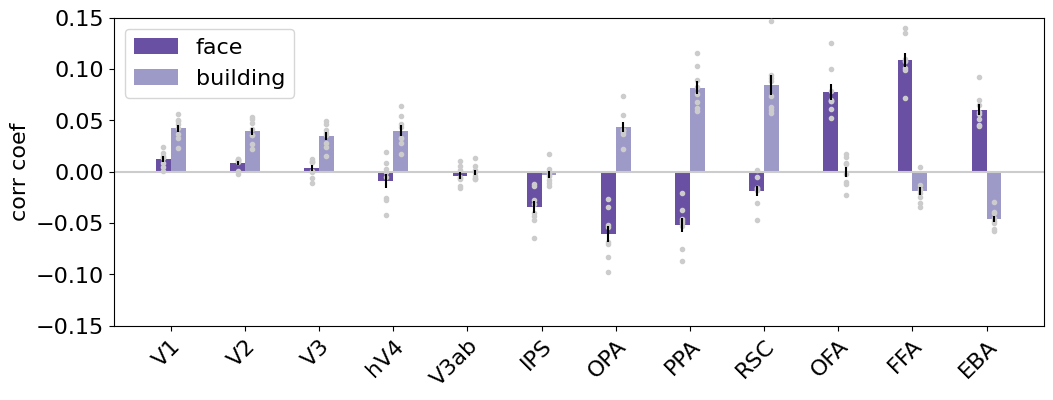

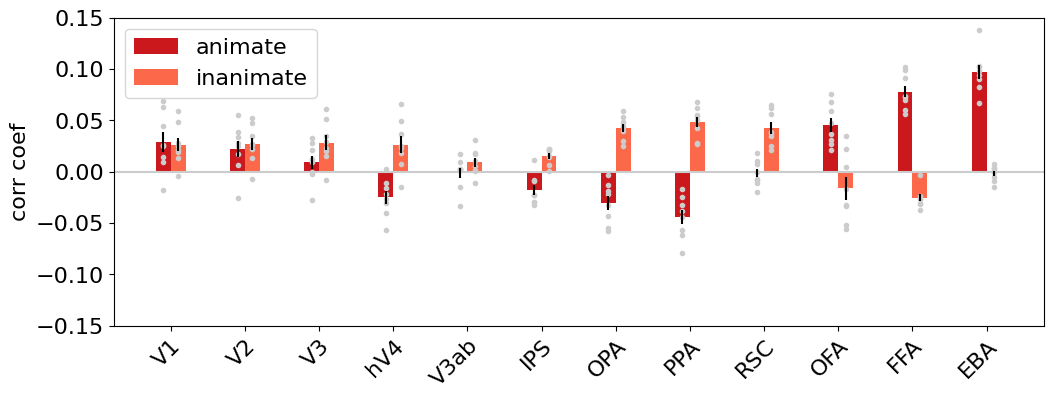

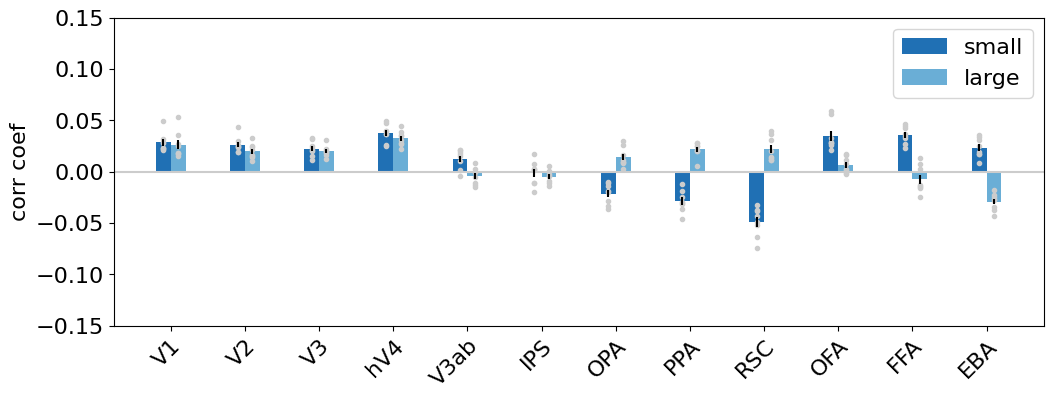

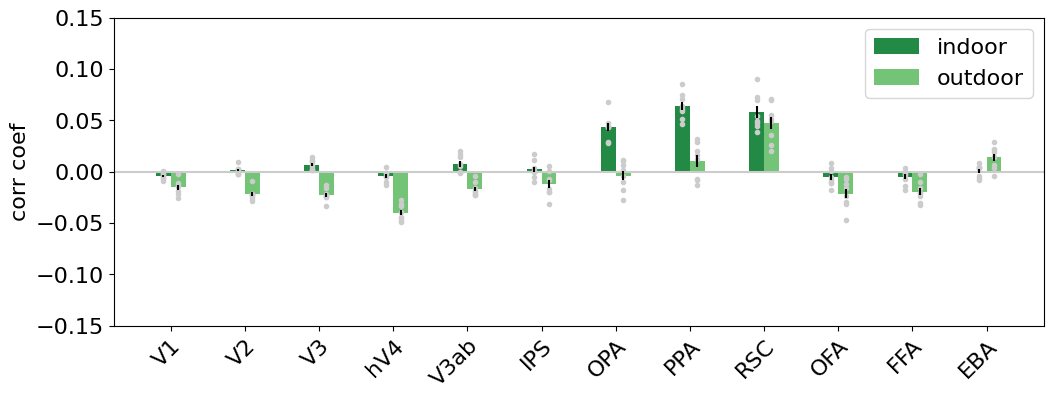

In [6]:
nc_thresh = 0.01
roi_mean_vals = np.zeros((n_rois, n_categ, n_subjects))

for si in range(n_subjects):

    nc = noise_ceilings[si]
    vox2use = nc>nc_thresh
    vals = partial_corrs[si]
    
    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for axes_plot in [[0,1],[2,3],[4,5],[6,7]]:
 
    bw = 0.2;
    space = (1 - (bw*len(axes_plot)))/2
                  
    point_data = np.moveaxis(roi_mean_vals[:,axes_plot,:], [0,1,2], [1,2,0])
    print(np.min(point_data), np.max(point_data))
    fh = plot_utils.plot_multi_bars(mean_data=mean_vals[:,axes_plot], err_data=sem_vals[:,axes_plot], \
                                    point_data = point_data, \
                                    colors=colors[axes_plot,:], space=space, \
                xticklabels=roi_names, ylabel='corr coef', \
                ylim=[-0.15, 0.15], horizontal_line_pos=0,\
                legend_labels=np.array(categ_names)[axes_plot], \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(12,4))

    fn2save = os.path.join(default_paths.fig_path, \
                           'categ_selectivity_%s-%s.pdf'%(categ_names[axes_plot[0]], \
                                                          categ_names[axes_plot[1]]))
    print(fn2save)
    plt.savefig(fn2save)

#### load the top category-selective voxels here

In [7]:
from analyze_fits import sem_voxel_groups
sem_groups, sem_group_names = sem_voxel_groups.get_sem_voxel_groups()
n_sem_groups = len(sem_group_names)

#### Make Supplementary Figure 5

Use PyCortex to make surface plots

In [8]:
from plotting import pycortex_plot_utils
volumes = {}
out = [load_fits.load_fit_results(ss, fitting_type,n_from_end=0,verbose=False) for ss in subjects]

mm=0;
nc_thresh = 0.01

for si, ss in zip([0],subjects[[0]]):
    
# for si, ss in enumerate(subjects):

    nc = noise_ceilings[si]
    vox2plot = nc>nc_thresh
 
    vals_partial = copy.deepcopy(partial_corrs[si])
   
    names = []
    maps = []
    cmaps = []
    mins = []
    maxes = []
            
    for cc in range(n_categ):
        
        names += ['S%d: %s partial'%(ss, categ_names[cc])]
        maps += [vals_partial[cc,:]]
        cmaps += ['RdBu']
        mins += [-0.3]
        maxes += [0.3]
        
    for gg in range(n_sem_groups):
        
        names += ['S%d: top %s vox'%(ss, sem_group_names[gg])]
        maps += [sem_groups[si][:,gg].astype(float)]
        cmaps += ['Blues']
        mins += [-0.1]
        maxes += [1.1]
      
    voxel_mask = out[si]['voxel_mask']
    nii_shape = out[si]['brain_nii_shape']
    mask_3d = np.reshape(voxel_mask, nii_shape, order='C')

    vol_ss = pycortex_plot_utils.maps_to_volumes(ss, maps, names, \
                         cmaps=cmaps, mins=mins, maxes=maxes, \
                         voxel_mask=voxel_mask, nii_shape=nii_shape, mask_3d=mask_3d, \
                         vox2plot=vox2plot)

    volumes.update(vol_ss)
    

In [9]:
viewer = pycortex_plot_utils.plot_with_overlays(volumes, title='Semantic selectivity partial corrs', \
                                                port = 14447, \
                                                labels_on=False, recache=False, \
                                                overlay_type = 'overlays')

using overlays from /user_data/mmhender/pycortex_db/subj01/overlays.svg
navigate browser to: 127.0.0.1:14447
Started server on port 14447
Stopping server


#### Set view and save images of flatmaps

In [7]:
# load pre-made view params from a json file
# (json files are in your pycortex database folder, under subj01/views/)

viewname='flat'
# viewname='left-tilt'
# viewname='right-tilt'
# viewname='bottom'

viewer.get_view('subj01',viewname)

# to make the view:
# viewer.save_view('subj01','flat1',True)

In [15]:
ss = 1;
cc = 7;

fn2save = os.path.join(default_paths.fig_path, \
                       'S%02d_partialcorr_%s_%s_raw.png'%(ss,categ_names[cc],viewname))
print('saving to %s'%fn2save)
viewer.getImage(fn2save, \
                size=(3000,3000))

saving to /user_data/mmhender/image_stats_gabor/figures/S01_partialcorr_outdoor_flat_raw.png


[{}]

In [16]:
# cropping the images
subject_bboxes = {'subj01':[620,900,2220,2500], 'subj02':[620,900,2220,2500], \
                  'subj03': [620,800,2220,2400], 'subj04': [620,750,2220,2350], \
                  'subj05': [620,800,2220,2400], 'subj06': [620,1050,2220,2650], \
                  'subj07': [620,800,2220,2400], 'subj08': [620,900,2220,2500]}

In [17]:
import PIL
for cc in range(n_categ):
    
    bbox = subject_bboxes['subj%02d'%ss]
    fn2save = os.path.join(default_paths.fig_path, \
                           'S%02d_partialcorr_%s_%s_raw.png'%(ss,categ_names[cc],viewname))
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                           'S%02d_partialcorr_%s_%s_cropped.png'%(ss,categ_names[cc],viewname))
    im = PIL.Image.open(fn2save)
    print(im.size[0])
    if im.size[0]==3000:
        pycortex_plot_utils.crop_image(fn2save, fn2save_cropped, bbox_new=bbox)

3000
3000
3000
3000
3000
3000
3000
3000


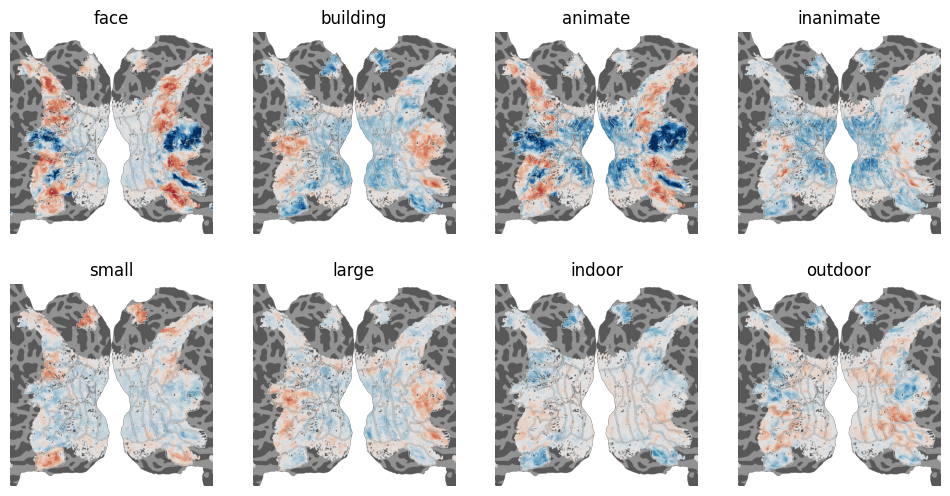

Stopping server


In [20]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

plt.figure(figsize=(12,6))

for cc in range(n_categ):
    
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                           'S%02d_partialcorr_%s_%s_cropped.png'%(ss,categ_names[cc],viewname))
    im = PIL.Image.open(fn2save_cropped)

    plt.subplot(2,4,cc+1);
    plt.imshow(im)
    plt.title('%s'%categ_names[cc])
    plt.axis('off')
    
fn2save = os.path.join(default_paths.fig_path, 'category_corrs_flatmaps.pdf')
plt.savefig(fn2save,dpi=1000)